In [156]:
import optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.Supervised import LazyRegressor

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

# local Module
import pre_processing_funcs as pre

In [119]:
df = pd.read_csv("data/cleaned_train.csv")
df.head()

,Promotion Name,Store Kind,Store Cost,Is Recyclable?,Grocery Area,Frozen Area,Meat Area,Cost,Marriage,Gender,...,Country ISO2,Order Brand,Order,Department,Coffee Bar,Video Store,Gross Weight,Package Weight,Min. Person Yearly Income,Family Expenses
0,Dimes Off,Deluxe,4292400.00,True,2037.64,481.98,323.00,602.76,Single,Female,...,ZA,Red Wing,Cleaning Supplies,Household,1,1,28.20,1.60,10000.00,2000.00
1,Budget Bargains,Supermarket,1971600.00,False,2049.72,457.36,305.02,708.66,Single,Female,...,WA,Nationeel,Snack Foods,Snack Foods,0,0,16.57,1.60,50000.00,12500.00
2,Shelf Emptiers,Supermarket,4452600.00,True,1322.21,523.32,348.85,564.26,Married,Male,...,CA,Excel,Magazines,Periodicals,0,0,28.64,1.45,30000.00,7500.00
3,Sale Winners,Deluxe,4970800.00,False,1872.19,593.93,395.95,519.76,Married,Female,...,YU,Hermanos,Vegetables,Produce,1,1,12.62,2.91,50000.00,7142.86
4,Weekend Discount,Supermarket,1618200.00,True,1236.07,440.92,293.95,364.16,Single,Male,...,WA,Red Wing,Candles,Household,1,0,15.41,1.45,30000.00,6000.00


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28227 entries, 0 to 28226
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Promotion Name             28227 non-null  object 
 1   Store Kind                 28227 non-null  object 
 2   Store Cost                 28227 non-null  float64
 3   Is Recyclable?             28227 non-null  bool   
 4   Grocery Area               28227 non-null  float64
 5   Frozen Area                28227 non-null  float64
 6   Meat Area                  28227 non-null  float64
 7   Cost                       28227 non-null  float64
 8   Marriage                   28227 non-null  object 
 9   Gender                     28227 non-null  object 
 10  Children                   28227 non-null  int64  
 11  Degree                     28227 non-null  object 
 12  Work                       28227 non-null  object 
 13  Store Code                 28227 non-null  obj

In [121]:
target = "Cost"
X = df.drop(columns=target)
y = df[target]

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
ord_categorical_columns = ['Store Code', 'Promotion Name', 'Store Kind',
                            'Degree', 'Work', 'Order Brand',
                            'Order', 'Department', "Country ISO2"]

hot_categorical_columns = ['Marriage', 'Gender', 'Is Recyclable?']

numeric_columns = X.select_dtypes("float").columns

In [124]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), ord_categorical_columns),
        ('ohe', OneHotEncoder(), hot_categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ]
)

In [125]:
model = make_pipeline(
    preprocessor,
    DecisionTreeRegressor(max_depth=16, random_state=42)
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['Store Code',
                                                   'Promotion Name',
                                                   'Store Kind', 'Degree',
                                                   'Work', 'Order Brand',
                                                   'Order', 'Department',
                                                   'Country ISO2']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?']),
                                                 ('num', StandardScaler(),
                                                  Index(['Store Cost', 'Grocery Area', 'Frozen Area', 'Meat Area',
       'Gross Weight', 'Package Weight', 'Min. Person

In [126]:
# Check if the model fitted well or not
predictions = model.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

29.84034188867323

In [127]:
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

62.73618023877335

In [128]:
rfmodel = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=512, max_depth=16, n_jobs=-1, random_state=42)
)
rfmodel.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['Store Code',
                                                   'Promotion Name',
                                                   'Store Kind', 'Degree',
                                                   'Work', 'Order Brand',
                                                   'Order', 'Department',
                                                   'Country ISO2']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?']),
                                                 ('num', StandardScaler(),
                                                  Index(['Store Cost', 'Grocery Area', 'Frozen Area', 'Meat Area',
       'Gross Weight', 'Package Weight', 'Min. Person

In [129]:
# Check if the model fitted well or not
predictions = rfmodel.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

28.49574232739305

In [130]:
predictions = rfmodel.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

50.93534844276737

In [131]:
exmodel = make_pipeline(
    preprocessor,
    ExtraTreesRegressor(n_estimators=512, max_depth=16, n_jobs=-1, random_state=42)
)
exmodel.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['Store Code',
                                                   'Promotion Name',
                                                   'Store Kind', 'Degree',
                                                   'Work', 'Order Brand',
                                                   'Order', 'Department',
                                                   'Country ISO2']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?']),
                                                 ('num', StandardScaler(),
                                                  Index(['Store Cost', 'Grocery Area', 'Frozen Area', 'Meat Area',
       'Gross Weight', 'Package Weight', 'Min. Person

In [132]:
# Check if the model fitted well or not
predictions = exmodel.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

25.43636870833475

In [133]:
predictions = exmodel.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

47.51236712353415

In [77]:
# iterate over 25 to 500 step 25 on number of estimators for model
i=1
for n in range(25, 501, 25):
    bag = make_pipeline(
        preprocessor,
        BaggingRegressor(n_estimators=n, n_jobs=-1, random_state=42)
    )
    bag.fit(X_train, y_train)
    
    predictions = bag.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, predictions))
    
    predictions = bag.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    print(f"Step: {i}/{500//25}, Train: {train_rmse}, Test {test_rmse} FOR {n} estmators")
    i+=1

Step: 1/20, Train: 20.691946017180335, Test 52.38068199283689 FOR 25 estmators
Step: 2/20, Train: 19.716835678007865, Test 51.44348656552273 FOR 50 estmators
Step: 3/20, Train: 19.332714608466727, Test 51.18042644580216 FOR 75 estmators
Step: 4/20, Train: 19.196096765531266, Test 51.385483385146834 FOR 100 estmators
Step: 5/20, Train: 19.094419751509044, Test 51.2262897664279 FOR 125 estmators
Step: 6/20, Train: 19.03297251489793, Test 51.38341370035767 FOR 150 estmators
Step: 7/20, Train: 19.0062631280202, Test 51.28403753119737 FOR 175 estmators
Step: 8/20, Train: 18.979088942478224, Test 51.3282213744781 FOR 200 estmators
Step: 9/20, Train: 18.998967013470065, Test 51.348827967676904 FOR 225 estmators
Step: 10/20, Train: 18.984193862414386, Test 51.3546248931016 FOR 250 estmators
Step: 11/20, Train: 18.982902737058563, Test 51.31038359083885 FOR 275 estmators
Step: 12/20, Train: 18.984432779332455, Test 51.321619804408435 FOR 300 estmators
Step: 13/20, Train: 18.95686141278588, Test

KeyboardInterrupt: 

In [46]:
# Check if the model fitted well or not
predictions = bag.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

19.196096765531266

In [47]:
# Check if the model fitted well or not
predictions = bag.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

51.385483385146834

In [85]:
cat = CatBoostRegressor(
    iterations=1000,
    random_state=42,
    loss_function='RMSE',
)
cat.fit(
    X_train,
    y_train,
    cat_features=list(X_train.select_dtypes("object").columns),
    eval_set=(X_test, y_test),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.083068
0:	learn: 148.1170170	test: 149.2295572	best: 149.2295572 (0)	total: 232ms	remaining: 3m 51s
1:	learn: 140.5918373	test: 141.4945277	best: 141.4945277 (1)	total: 292ms	remaining: 2m 25s
2:	learn: 133.6687275	test: 134.4114863	best: 134.4114863 (2)	total: 341ms	remaining: 1m 53s
3:	learn: 127.2718803	test: 127.7732038	best: 127.7732038 (3)	total: 393ms	remaining: 1m 37s
4:	learn: 121.5183438	test: 121.8560280	best: 121.8560280 (4)	total: 443ms	remaining: 1m 28s
5:	learn: 116.6982574	test: 116.7635751	best: 116.7635751 (5)	total: 486ms	remaining: 1m 20s
6:	learn: 112.2966793	test: 112.2043661	best: 112.2043661 (6)	total: 526ms	remaining: 1m 14s
7:	learn: 108.1972634	test: 107.9832651	best: 107.9832651 (7)	total: 572ms	remaining: 1m 10s
8:	learn: 104.3800379	test: 103.9986874	best: 103.9986874 (8)	total: 642ms	remaining: 1m 10s
9:	learn: 101.1462354	test: 100.5890978	best: 100.5890978 (9)	total: 693ms	remaining: 1m 8s
10:	learn: 98.4183226	test: 97.7155336	be

92:	learn: 62.1172132	test: 59.1961730	best: 59.1961730 (92)	total: 4.92s	remaining: 48s
93:	learn: 62.1061997	test: 59.1967588	best: 59.1961730 (92)	total: 4.97s	remaining: 47.9s
94:	learn: 62.0934637	test: 59.1894202	best: 59.1894202 (94)	total: 5.03s	remaining: 47.9s
95:	learn: 62.0847674	test: 59.1879986	best: 59.1879986 (95)	total: 5.08s	remaining: 47.8s
96:	learn: 62.0795681	test: 59.1875152	best: 59.1875152 (96)	total: 5.13s	remaining: 47.8s
97:	learn: 62.0689429	test: 59.1859258	best: 59.1859258 (97)	total: 5.19s	remaining: 47.7s
98:	learn: 62.0030657	test: 59.1224464	best: 59.1224464 (98)	total: 5.25s	remaining: 47.8s
99:	learn: 61.9828288	test: 59.1065446	best: 59.1065446 (99)	total: 5.31s	remaining: 47.8s
100:	learn: 61.9500945	test: 59.0770505	best: 59.0770505 (100)	total: 5.36s	remaining: 47.7s
101:	learn: 61.9097663	test: 59.0306899	best: 59.0306899 (101)	total: 5.4s	remaining: 47.6s
102:	learn: 61.7879798	test: 58.9187921	best: 58.9187921 (102)	total: 5.46s	remaining: 47

184:	learn: 58.5355802	test: 56.1652282	best: 56.1611912 (183)	total: 9.53s	remaining: 42s
185:	learn: 58.5072527	test: 56.1814889	best: 56.1611912 (183)	total: 9.58s	remaining: 41.9s
186:	learn: 58.4940532	test: 56.1757427	best: 56.1611912 (183)	total: 9.64s	remaining: 41.9s
187:	learn: 58.4880196	test: 56.1757950	best: 56.1611912 (183)	total: 9.69s	remaining: 41.8s
188:	learn: 58.4245150	test: 56.1219113	best: 56.1219113 (188)	total: 9.76s	remaining: 41.9s
189:	learn: 58.4138227	test: 56.1224368	best: 56.1219113 (188)	total: 9.83s	remaining: 41.9s
190:	learn: 58.2647324	test: 55.9631564	best: 55.9631564 (190)	total: 9.88s	remaining: 41.9s
191:	learn: 58.2586637	test: 55.9624912	best: 55.9624912 (191)	total: 9.94s	remaining: 41.8s
192:	learn: 58.2217017	test: 55.9411241	best: 55.9411241 (192)	total: 9.99s	remaining: 41.8s
193:	learn: 58.1364202	test: 55.8575535	best: 55.8575535 (193)	total: 10s	remaining: 41.7s
194:	learn: 58.0788504	test: 55.7992336	best: 55.7992336 (194)	total: 10.1

277:	learn: 56.3972458	test: 54.7445216	best: 54.7445216 (277)	total: 14.5s	remaining: 37.8s
278:	learn: 56.2757323	test: 54.6204947	best: 54.6204947 (278)	total: 14.6s	remaining: 37.7s
279:	learn: 56.2741213	test: 54.6204845	best: 54.6204845 (279)	total: 14.7s	remaining: 37.7s
280:	learn: 56.1725842	test: 54.5098366	best: 54.5098366 (280)	total: 14.7s	remaining: 37.7s
281:	learn: 56.1723391	test: 54.5098363	best: 54.5098363 (281)	total: 14.8s	remaining: 37.6s
282:	learn: 56.1259216	test: 54.4963420	best: 54.4963420 (282)	total: 14.8s	remaining: 37.6s
283:	learn: 56.1249509	test: 54.4962430	best: 54.4962430 (283)	total: 14.9s	remaining: 37.6s
284:	learn: 56.1120862	test: 54.4928844	best: 54.4928844 (284)	total: 14.9s	remaining: 37.5s
285:	learn: 56.1087929	test: 54.4914813	best: 54.4914813 (285)	total: 15s	remaining: 37.4s
286:	learn: 56.0982761	test: 54.4920647	best: 54.4914813 (285)	total: 15.1s	remaining: 37.4s
287:	learn: 56.0933825	test: 54.4937525	best: 54.4914813 (285)	total: 15

368:	learn: 54.0184567	test: 53.0779417	best: 53.0772575 (367)	total: 19.6s	remaining: 33.4s
369:	learn: 53.9873262	test: 53.0534438	best: 53.0534438 (369)	total: 19.6s	remaining: 33.4s
370:	learn: 53.9804595	test: 53.0531755	best: 53.0531755 (370)	total: 19.7s	remaining: 33.3s
371:	learn: 53.9504262	test: 53.0434112	best: 53.0434112 (371)	total: 19.7s	remaining: 33.3s
372:	learn: 53.9235860	test: 53.0183768	best: 53.0183768 (372)	total: 19.8s	remaining: 33.2s
373:	learn: 53.9223669	test: 53.0185483	best: 53.0183768 (372)	total: 19.8s	remaining: 33.2s
374:	learn: 53.8988565	test: 53.0031103	best: 53.0031103 (374)	total: 19.9s	remaining: 33.2s
375:	learn: 53.8367046	test: 52.9636579	best: 52.9636579 (375)	total: 19.9s	remaining: 33.1s
376:	learn: 53.8288959	test: 52.9624881	best: 52.9624881 (376)	total: 20s	remaining: 33.1s
377:	learn: 53.8231817	test: 52.9620532	best: 52.9620532 (377)	total: 20.1s	remaining: 33s
378:	learn: 53.8089230	test: 52.9546656	best: 52.9546656 (378)	total: 20.1

458:	learn: 52.7204893	test: 52.6220814	best: 52.6218932 (457)	total: 24.5s	remaining: 28.9s
459:	learn: 52.7161624	test: 52.6202911	best: 52.6202911 (459)	total: 24.5s	remaining: 28.8s
460:	learn: 52.7062465	test: 52.6176368	best: 52.6176368 (460)	total: 24.6s	remaining: 28.8s
461:	learn: 52.6969520	test: 52.6084515	best: 52.6084515 (461)	total: 24.7s	remaining: 28.7s
462:	learn: 52.6947008	test: 52.6092588	best: 52.6084515 (461)	total: 24.7s	remaining: 28.7s
463:	learn: 52.6678811	test: 52.5850338	best: 52.5850338 (463)	total: 24.7s	remaining: 28.6s
464:	learn: 52.6581592	test: 52.5831854	best: 52.5831854 (464)	total: 24.8s	remaining: 28.5s
465:	learn: 52.6495155	test: 52.5814794	best: 52.5814794 (465)	total: 24.8s	remaining: 28.5s
466:	learn: 52.6378096	test: 52.5747855	best: 52.5747855 (466)	total: 24.9s	remaining: 28.4s
467:	learn: 52.6326837	test: 52.5744675	best: 52.5744675 (467)	total: 24.9s	remaining: 28.3s
468:	learn: 52.6298665	test: 52.5740146	best: 52.5740146 (468)	total: 

548:	learn: 51.6990655	test: 52.2519534	best: 52.2423591 (542)	total: 29.5s	remaining: 24.2s
549:	learn: 51.6680432	test: 52.2268330	best: 52.2268330 (549)	total: 29.5s	remaining: 24.2s
550:	learn: 51.6571494	test: 52.2264056	best: 52.2264056 (550)	total: 29.6s	remaining: 24.1s
551:	learn: 51.6448345	test: 52.2254502	best: 52.2254502 (551)	total: 29.7s	remaining: 24.1s
552:	learn: 51.6414806	test: 52.2273655	best: 52.2254502 (551)	total: 29.7s	remaining: 24s
553:	learn: 51.6275006	test: 52.2293070	best: 52.2254502 (551)	total: 29.8s	remaining: 24s
554:	learn: 51.6263939	test: 52.2299863	best: 52.2254502 (551)	total: 29.8s	remaining: 23.9s
555:	learn: 51.6003208	test: 52.2092676	best: 52.2092676 (555)	total: 29.9s	remaining: 23.9s
556:	learn: 51.5870358	test: 52.1986117	best: 52.1986117 (556)	total: 30s	remaining: 23.8s
557:	learn: 51.5600251	test: 52.2194377	best: 52.1986117 (556)	total: 30s	remaining: 23.8s
558:	learn: 51.5572995	test: 52.2199577	best: 52.1986117 (556)	total: 30.1s	re

638:	learn: 50.6435321	test: 52.0413758	best: 52.0331860 (636)	total: 34.6s	remaining: 19.5s
639:	learn: 50.6349645	test: 52.0406007	best: 52.0331860 (636)	total: 34.6s	remaining: 19.5s
640:	learn: 50.6165338	test: 52.0301983	best: 52.0301983 (640)	total: 34.7s	remaining: 19.4s
641:	learn: 50.6103847	test: 52.0307407	best: 52.0301983 (640)	total: 34.7s	remaining: 19.4s
642:	learn: 50.6016074	test: 52.0300568	best: 52.0300568 (642)	total: 34.8s	remaining: 19.3s
643:	learn: 50.5999556	test: 52.0293067	best: 52.0293067 (643)	total: 34.9s	remaining: 19.3s
644:	learn: 50.5948699	test: 52.0295443	best: 52.0293067 (643)	total: 34.9s	remaining: 19.2s
645:	learn: 50.5864700	test: 52.0271163	best: 52.0271163 (645)	total: 35s	remaining: 19.2s
646:	learn: 50.5507031	test: 51.9918459	best: 51.9918459 (646)	total: 35s	remaining: 19.1s
647:	learn: 50.5364609	test: 51.9849342	best: 51.9849342 (647)	total: 35.1s	remaining: 19.1s
648:	learn: 50.5244404	test: 51.9848951	best: 51.9848951 (648)	total: 35.1

729:	learn: 49.7907722	test: 51.9038548	best: 51.9038548 (729)	total: 39.7s	remaining: 14.7s
730:	learn: 49.7878037	test: 51.9036007	best: 51.9036007 (730)	total: 39.8s	remaining: 14.6s
731:	learn: 49.7849512	test: 51.9043162	best: 51.9036007 (730)	total: 39.8s	remaining: 14.6s
732:	learn: 49.7784081	test: 51.9053569	best: 51.9036007 (730)	total: 39.9s	remaining: 14.5s
733:	learn: 49.7653691	test: 51.9034672	best: 51.9034672 (733)	total: 40s	remaining: 14.5s
734:	learn: 49.7566062	test: 51.9047284	best: 51.9034672 (733)	total: 40s	remaining: 14.4s
735:	learn: 49.7529516	test: 51.9051970	best: 51.9034672 (733)	total: 40.1s	remaining: 14.4s
736:	learn: 49.7398207	test: 51.9037676	best: 51.9034672 (733)	total: 40.1s	remaining: 14.3s
737:	learn: 49.7340498	test: 51.9016361	best: 51.9016361 (737)	total: 40.2s	remaining: 14.3s
738:	learn: 49.7062670	test: 51.9024014	best: 51.9016361 (737)	total: 40.2s	remaining: 14.2s
739:	learn: 49.7025254	test: 51.9032747	best: 51.9016361 (737)	total: 40.3

819:	learn: 48.9172880	test: 51.7268000	best: 51.7212654 (807)	total: 44.8s	remaining: 9.84s
820:	learn: 48.9081352	test: 51.7263710	best: 51.7212654 (807)	total: 44.9s	remaining: 9.79s
821:	learn: 48.9005036	test: 51.7261877	best: 51.7212654 (807)	total: 45s	remaining: 9.74s
822:	learn: 48.8650397	test: 51.7079824	best: 51.7079824 (822)	total: 45s	remaining: 9.69s
823:	learn: 48.8472854	test: 51.7024524	best: 51.7024524 (823)	total: 45.1s	remaining: 9.63s
824:	learn: 48.8246358	test: 51.6884698	best: 51.6884698 (824)	total: 45.1s	remaining: 9.58s
825:	learn: 48.8169384	test: 51.6869853	best: 51.6869853 (825)	total: 45.2s	remaining: 9.53s
826:	learn: 48.8151107	test: 51.6869289	best: 51.6869289 (826)	total: 45.3s	remaining: 9.47s
827:	learn: 48.8033949	test: 51.6832667	best: 51.6832667 (827)	total: 45.3s	remaining: 9.42s
828:	learn: 48.7887436	test: 51.6818063	best: 51.6818063 (828)	total: 45.4s	remaining: 9.37s
829:	learn: 48.7835698	test: 51.6820992	best: 51.6818063 (828)	total: 45.5

909:	learn: 47.8926226	test: 51.4481465	best: 51.4481465 (909)	total: 50.3s	remaining: 4.97s
910:	learn: 47.8918452	test: 51.4480313	best: 51.4480313 (910)	total: 50.3s	remaining: 4.92s
911:	learn: 47.8892377	test: 51.4461947	best: 51.4461947 (911)	total: 50.4s	remaining: 4.86s
912:	learn: 47.8858434	test: 51.4474198	best: 51.4461947 (911)	total: 50.4s	remaining: 4.8s
913:	learn: 47.8837174	test: 51.4468421	best: 51.4461947 (911)	total: 50.5s	remaining: 4.75s
914:	learn: 47.8630176	test: 51.4361095	best: 51.4361095 (914)	total: 50.6s	remaining: 4.7s
915:	learn: 47.8614930	test: 51.4359193	best: 51.4359193 (915)	total: 50.6s	remaining: 4.64s
916:	learn: 47.8489806	test: 51.4344981	best: 51.4344981 (916)	total: 50.7s	remaining: 4.59s
917:	learn: 47.8256351	test: 51.4374443	best: 51.4344981 (916)	total: 50.7s	remaining: 4.53s
918:	learn: 47.8198698	test: 51.4370577	best: 51.4344981 (916)	total: 50.8s	remaining: 4.48s
919:	learn: 47.8024060	test: 51.4322616	best: 51.4322616 (919)	total: 50

998:	learn: 47.1377888	test: 51.2776084	best: 51.2600346 (985)	total: 55.2s	remaining: 55.3ms
999:	learn: 47.1210076	test: 51.2913821	best: 51.2600346 (985)	total: 55.3s	remaining: 0us

bestTest = 51.26003462
bestIteration = 985

Shrink model to first 986 iterations.


In [19]:
np.sqrt(mean_squared_error(y_train, cat.predict(X_train)))

31.823976044377062

In [20]:
np.sqrt(mean_squared_error(y_test, cat.predict(X_test)))

49.506535427243314

In [26]:
# falied with creating new columns from existing one

# Store Sales / Income -- Store Monthly Profit Per Family
# df["Store Monthly Profit Per Family"] = df["Store Sales"] / df["Min. Person Yearly Income"]

# Store Sales / Family Expenses -- Store Monthly Profit Per Person

# df["Store Monthly Profit Per Person"] = df["Store Sales"] / df["Family Expenses"]

# df["Person Gross"] = (df["Min. Person Yearly Income"] / df["Gross Weight"])

<AxesSubplot:>

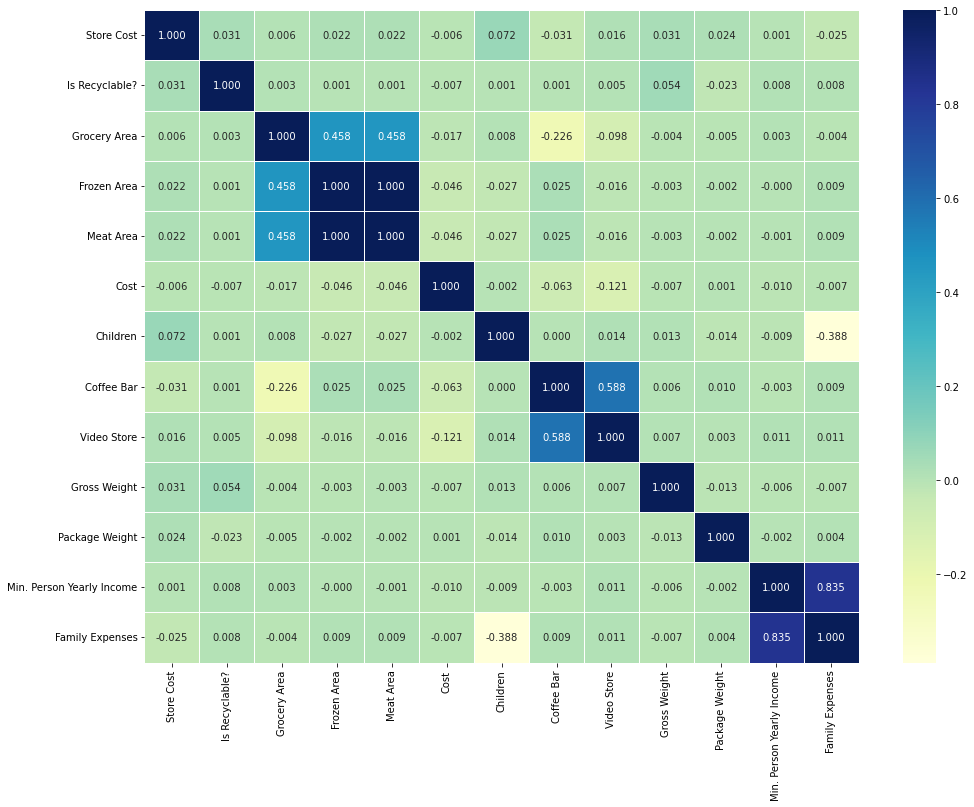

In [134]:
plt.figure(figsize=(16, 12)) 
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, fmt='.3f', linewidths=0.5)

## Try Lazypredict

In [135]:
preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [ ]:
reg = LazyRegressor(verbose=1,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(X_train_transformed, X_test_transformed, y_train, y_test)

  2%|█▉                                                                                 | 1/42 [00:00<00:30,  1.36it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.11951398275585212, 'Adjusted R-Squared': 0.11591185212678501, 'RMSE': 148.325966715588, 'Time taken': 0.7345890998840332}


  5%|███▉                                                                               | 2/42 [00:02<00:44,  1.11s/it]

{'Model': 'BaggingRegressor', 'R-Squared': 0.883992270791659, 'Adjusted R-Squared': 0.8835176749588963, 'RMSE': 53.839301735502104, 'Time taken': 1.3652608394622803}
{'Model': 'BayesianRidge', 'R-Squared': 0.016597207221532906, 'Adjusted R-Squared': 0.01257403677793556, 'RMSE': 156.75509821032546, 'Time taken': 0.06705069541931152}


 14%|███████████▊                                                                       | 6/42 [00:02<00:10,  3.44it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.806057999080857, 'Adjusted R-Squared': 0.8052645686253002, 'RMSE': 69.61324709258274, 'Time taken': 0.2188725471496582}
{'Model': 'DummyRegressor', 'R-Squared': -0.00035584667892929467, 'Adjusted R-Squared': -0.004448373266196404, 'RMSE': 158.1004889993646, 'Time taken': 0.03998064994812012}
{'Model': 'ElasticNet', 'R-Squared': 0.013091159546234632, 'Adjusted R-Squared': 0.009053645613392836, 'RMSE': 157.03428282819402, 'Time taken': 0.06810545921325684}


 19%|███████████████▊                                                                   | 8/42 [00:02<00:08,  3.93it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.016410570387165646, 'Adjusted R-Squared': 0.012386636399066231, 'RMSE': 156.76997252608598, 'Time taken': 0.3593733310699463}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7643956744161657, 'Adjusted R-Squared': 0.7634318004409918, 'RMSE': 76.72688832022743, 'Time taken': 0.10393381118774414}


 21%|█████████████████▊                                                                 | 9/42 [00:09<01:07,  2.06s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9092880169599066, 'Adjusted R-Squared': 0.9089169078154878, 'RMSE': 47.6089152494829, 'Time taken': 6.828190565109253}
{'Model': 'GammaRegressor', 'R-Squared': 0.011453334207532362, 'Adjusted R-Squared': 0.007409119815282916, 'RMSE': 157.16453199531364, 'Time taken': 0.06403827667236328}


In [ ]:
print(models)

## ExtraTreesRegressor

In [ ]:
# GridSearch for ExtraTree Regressor
params = {
    'n_estimators': range(100, 501, 100),
    'max_depth': [2, 8, 16, 32, 64],
    'min_samples_split': [2,4],
    'min_samples_leaf': [1,2],
}

GS_EXTRA = GridSearchCV(
    ExtraTreesRegressor(random_state=42, n_jobs=-1),
    param_grid=params,
    cv=3,
    n_jobs=-1,
    verbose=1
)

GS_EXTRA.fit(X_train_transformed, y_train)

In [ ]:
GS_EXTRA.best_params_

In [ ]:
EXTRA = GS_EXTRA.best_estimator_
EXTRA

## RandomForestRegressor

In [15]:
# GridSearch for RandomForest Regressor
params = {
    'n_estimators': range(100, 501, 100),
    'max_depth': [2, 8, 16, 32, 64],
    'min_samples_split': [2,4,6],
    'min_samples_leaf': [1,2,3],
    # 'max_features': ["sqrt", "log2"] add 1 is the default
}

GS_RF = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=params,
    cv=3,
    n_jobs=-1,
    verbose=1
)

GS_RF.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 450 candidates, totalling 1350 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 8, 16, 32, 64],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': range(100, 501, 100)},
             verbose=1)

In [16]:
GS_RF.best_params_

{'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [19]:
RF = GS_RF.best_estimator_
RF

RandomForestRegressor(max_depth=32, max_features='sqrt', n_estimators=500,
                      n_jobs=-1, random_state=42)

## BaggingRegressor

In [ ]:
# GridSearch for Bagging Regressor
params = {
    'n_estimators': range(100, 801, 20),
}

BAG_RF = GridSearchCV(
    BaggingRegressor(random_state=42, n_jobs=-1),
    param_grid=params,
    cv=3,
    n_jobs=-1,
    verbose=1
)

BAG_RF.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [ ]:
BAG_RF.best_params_

In [ ]:
BAG = BAG_RF.best_estimator_
BAG

## XGBRegressor

In [153]:
model = make_pipeline(preprocessor, XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=12, min_split_loss=5))
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['Store Code',
                                                   'Promotion Name',
                                                   'Store Kind', 'Degree',
                                                   'Work', 'Order Brand',
                                                   'Order', 'Department',
                                                   'Country ISO2']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?']),
                                                 ('num', StandardScaler(),
                                                  Index(['Store Cost', 'Grocery Area', 'Frozen Area', 'Meat Area',
       'Gross W...
                              feat

In [154]:
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.2f}')

Root Mean Squared Error: 52.73


In [ ]:
param_grid = {
    'xgbregressor__learning_rate': [0.01, 0.1],
    'xgbregressor__n_estimators': range(50, 501, 50),
    'xgbregressor__max_depth': [2, 4, 8, 16, 32],
    'xgbregressor__min_split_loss': range(0, 7, 2)
    
}


grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_transformed, y_train)

In [ ]:
y_pred = grid_search.predict(X_test_transformed)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.2f}')

In [ ]:
print(f'Best hyperparameters: {grid_search.best_params_}')

## LGBMRegressor

In [160]:
model = make_pipeline(preprocessor, LGBMRegressor())
model.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 22581, number of used features: 23
[LightGBM] [Info] Start training from score 518.858765


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['Store Code',
                                                   'Promotion Name',
                                                   'Store Kind', 'Degree',
                                                   'Work', 'Order Brand',
                                                   'Order', 'Department',
                                                   'Country ISO2']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?']),
                                                 ('num', StandardScaler(),
                                                  Index(['Store Cost', 'Grocery Area', 'Frozen Area', 'Meat Area',
       'Gross Weight', 'Package Weight', 'Min. Person

In [162]:
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.2f}')

Root Mean Squared Error: 63.83


In [ ]:
param_grid = {
    'lgbmregressor__learning_rate': [0.01, 0.1],
    'lgbmregressor__n_estimators': range(50, 501, 50),
    'lgbmregressor__num_leaves': [31, 45, 61],
    'lgbmregressor__max_depth': [2, 4, 8, 16, 32],
}

grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_transformed, y_train)

In [161]:
y_pred = grid_search.predict(X_test_transformed)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.2f}')

In [ ]:
print(f'Best hyperparameters: {grid_search.best_params_}')

## Stacking & Boosting

In [86]:
rf = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=512, max_depth=16, n_jobs=-1, random_state=42)
)

et = make_pipeline(
    preprocessor,
    ExtraTreesRegressor(n_estimators=512, max_depth=16, n_jobs=-1, random_state=42)
)

bag = make_pipeline(
    preprocessor,
    BaggingRegressor(n_estimators=75, n_jobs=-1, random_state=42)
)


#lr = LogisticRegression(random_state=0, max_iter=500, C = 10, penalty= 'l2', solver= 'newton-cg')

#mlp = MLPClassifier(random_state=0, hidden_layer_sizes = (512,) , max_iter=100, early_stopping=True,
              #      solver='adam', learning_rate = 'adaptive', alpha=0.001, activation='relu', batch_size=128)

#gb = GradientBoostingClassifier(random_state=0, learning_rate=0.1, n_estimators=100)

#hgb = HistGradientBoostingClassifier(random_state=0, learning_rate=0.01, l2_regularization=0.001)

#lgbm = LGBMClassifier(random_state=0, learning_rate=0.01, n_estimators=1000, num_leaves=10)

#cat = CatBoostClassifier(n_estimators=1500, learning_rate=0.05, random_state=0, eval_metric= 'MultiClass')

In [115]:
estimators = [
              ('rf', rf),
              ('et', et),
              ('bag', bag),
             ]

stack_model = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=42)

stack_model.fit(X_train, y_train)

StackingRegressor(estimators=[('rf',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('cat',
                                                                                 OrdinalEncoder(),
                                                                                 ['Store '
                                                                                  'Code',
                                                                                  'Promotion '
                                                                                  'Name',
                                                                                  'Store '
                                                                                  'Kind',
                                                                                  'Degree',
                                                                    

In [116]:
# Check if the model fitted well or not
predictions = stack_model.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

31.345668946816417

In [117]:
# Check if the model fitted well or not
predictions = stack_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

49.74260229469237

In [111]:
estimators = [
              ('rf', rf),
              ('et', et),
              ('bag', bag),
             ]

voting_model = VotingRegressor(estimators=estimators)

voting_model.fit(X_train, y_train)

VotingRegressor(estimators=[('rf',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OrdinalEncoder(),
                                                                               ['Store '
                                                                                'Code',
                                                                                'Promotion '
                                                                                'Name',
                                                                                'Store '
                                                                                'Kind',
                                                                                'Degree',
                                                                                'Work',
  

In [112]:
# Check if the model fitted well or not
predictions = voting_model.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

23.62320220148355

In [113]:
predictions = voting_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

49.18332521199632

## Optuna Optimization

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 64),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 6),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
    }
    
    model = ExtraTreesRegressor(**params, n_jobs=-1, random_state=42)


    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    scores=cross_val_score(model, X_train_transformed, y_train, cv=kf, scoring=rmse_scorer)
    positive_scores = (-scores).mean()


    return positive_scores

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

In [ ]:
# Print the best hyperparameters and corresponding RMSE
print("Best trial:")
trial = study.best_trial
print("Value (RMSE): {}".format(trial.value))
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

## Extract submissions

In [78]:
samples = pd.read_csv('data/sample_submission.csv')
samples.head()

,ID,Cost
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [79]:
test = pre.set_index(pre.wrangle(pd.read_csv("data/cleaned_test.csv")))
test.head()

,Promotion Name,Store Kind,Store Cost,Is Recyclable?,Grocery Area,Frozen Area,Meat Area,Marriage,Gender,Children,...,Country ISO2,Order Brand,Order,Department,Coffee Bar,Video Store,Gross Weight,Package Weight,Min. Person Yearly Income,Family Expenses
id,,,,,,,,,,,,,,,,,,,,,
0,Fantastic Discounts,Gourmet,4704000.00,True,1424.85,465.54,308.73,Single,Male,4,...,CA,Gulf Coast,Candy,Snacks,1,1,31.83,3.05,50000.00,10000.00
1,Bag Stuffer,Deluxe,669600.00,False,1735.17,505.07,336.59,Married,Female,3,...,OR,Golden,Vegetables,Frozen Foods,1,1,29.94,2.91,70000.00,14000.00
2,Pick Your Savings,Deluxe,823500.00,False,2038.11,481.98,321.26,Single,Female,3,...,ZA,Club,Dairy,Dairy,1,1,29.22,2.91,130000.00,32500.00
3,Price Winners,Deluxe,4410000.00,False,1871.16,593.93,394.58,Single,Male,3,...,YU,Imagine,Frozen Desserts,Frozen Foods,1,1,28.05,3.05,10000.00,2500.00
4,Dollar Days,Supermarket,1987200.00,False,1320.15,523.32,348.85,Single,Male,2,...,CA,BBB Best,Hot Beverages,Beverages,0,0,23.55,2.91,30000.00,10000.00


In [80]:
X_train.head()

,Promotion Name,Store Kind,Store Cost,Is Recyclable?,Grocery Area,Frozen Area,Meat Area,Marriage,Gender,Children,...,Country ISO2,Order Brand,Order,Department,Coffee Bar,Video Store,Gross Weight,Package Weight,Min. Person Yearly Income,Family Expenses
id,,,,,,,,,,,,,,,,,,,,,
mc_ID_2741,Three for One,Deluxe,3936000.00,False,1871.16,593.93,397.93,Married,Female,2,...,YU,Lake,Meat,Deli,1,1,9.68,1.47,30000.00,7500.00
mc_ID_18520,Savings Galore,Mid-Size,2970000.00,True,2542.02,390.97,260.65,Married,Female,5,...,BC,Ebony,Fruit,Produce,1,0,31.25,2.91,30000.00,4285.71
mc_ID_433,Sale Winners,Supermarket,1294800.00,False,1509.34,227.80,150.22,Single,Male,3,...,OR,Tri-State,Packaged Vegetables,Produce,0,0,19.77,2.91,10000.00,2500.00
mc_ID_17957,Shelf Emptiers,Gourmet,1111500.00,True,1566.09,387.45,256.97,Single,Female,4,...,ZA,Ebony,Specialty,Produce,1,0,12.05,1.47,50000.00,10000.00
mc_ID_74,Sale : Double Down,Deluxe,4692000.00,False,1732.11,503.07,336.95,Single,Female,2,...,OR,Tell Tale,Specialty,Produce,1,1,11.44,1.47,50000.00,16666.67


In [81]:
test.isna().sum()

Promotion Name               0
Store Kind                   0
Store Cost                   0
Is Recyclable?               0
Grocery Area                 0
Frozen Area                  0
Meat Area                    0
Marriage                     0
Gender                       0
Children                     0
Degree                       0
Work                         0
Store Code                   0
Country ISO2                 0
Order Brand                  0
Order                        0
Department                   0
Coffee Bar                   0
Video Store                  0
Gross Weight                 0
Package Weight               0
Min. Person Yearly Income    0
Family Expenses              0
dtype: int64

In [82]:
y_sub_pred = exmodel.predict(test)

In [83]:
samples["Cost"] = y_sub_pred

In [84]:
samples.to_csv("data/submission.csv", index=False)